In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("bank-full.csv", sep=";")

In [3]:
df = df[['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 
         'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]

In [4]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
df.y.value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

In [7]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [8]:
# Target encoding
df.y = (df.y == "yes").astype(int)

In [9]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [10]:
categorical

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [11]:
numerical = list(df.dtypes[df.dtypes == 'int'].index)

In [12]:
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']

In [13]:
numerical.remove("y")

In [14]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

#del df_train['y']
#del df_val['y']
#del df_test['y']

In [15]:
df_train.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,56,entrepreneur,married,tertiary,40,no,cellular,11,jul,123,2,-1,0,unknown,0
1,33,technician,married,secondary,4790,yes,cellular,20,apr,137,1,272,2,failure,0
2,32,technician,single,tertiary,392,yes,cellular,21,nov,148,2,-1,0,unknown,0
3,40,admin.,divorced,secondary,2129,no,cellular,30,apr,452,1,-1,0,unknown,1
4,54,unemployed,married,tertiary,1180,no,cellular,19,nov,394,2,-1,0,unknown,0


# Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the y variable
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* balance, day, duration, previous?

In [16]:
from sklearn.metrics import auc

In [17]:
# auc(df_train["y"], df_train["balance"]) # ValueError: x is neither increasing nor decreasing : [0 0 0 ... 0 0 0].

In [18]:
from sklearn.metrics import roc_auc_score

In [19]:
roc_auc_score(df_train["y"], df_train["balance"])

0.5888313805382317

In [20]:
roc_auc_score(df_train["y"], df_train["day"])

0.474042117616092

In [21]:
# If your AUC is < 0.5, invert this variable by putting "-" in front 
roc_auc_score(df_train["y"], -df_train["day"])

0.525957882383908

In [22]:
roc_auc_score(df_train["y"], df_train["duration"]) 

0.8147002759670778

In [23]:
roc_auc_score(df_train["y"], df_train["previous"])

0.5985653242764153

The answer is: duration has the highest AUC

# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

* LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.69, 0.79, 0.89, 0.99?

In [24]:
from sklearn.feature_extraction import DictVectorizer

In [25]:
del df_train['y']
del df_val['y']
del df_test['y']

In [26]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [29]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [30]:
y_pred = model.predict_proba(X_val) #[:, 1]

In [31]:
y_pred

array([[0.9700324 , 0.0299676 ],
       [0.97689557, 0.02310443],
       [0.9792229 , 0.0207771 ],
       ...,
       [0.75207714, 0.24792286],
       [0.99781078, 0.00218922],
       [0.96227721, 0.03772279]])

In [32]:
y_pred = model.predict_proba(X_val)[:, 1]

In [33]:
y_pred

array([0.0299676 , 0.02310443, 0.0207771 , ..., 0.24792286, 0.00218922,
       0.03772279])

In [34]:
roc_auc_score(y_val, y_pred)

0.9004143531129565

In [35]:
print ("The answer is: ", round(roc_auc_score(y_val, y_pred), 3))

The answer is:  0.9


# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

For each threshold, compute precision and recall

Plot them

At which threshold precision and recall curves intersect?

* 0.265, 0.465, 0.665, 0.865?

In [36]:
a = np.arange(0, 1, 0.01)
print (a)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


In [37]:
def p_r_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    #df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    #df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    return df_scores

In [42]:
df_p_r = p_r_dataframe(y_val, y_pred)

In [43]:
df_p_r.head()

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,1098,7944,0,0,0.121433,1.000000
1,0.01,1094,7004,4,940,0.135095,0.996357
2,0.02,1093,5788,5,2156,0.158843,0.995446
3,0.03,1087,4742,11,3202,0.186481,0.989982
4,0.04,1068,3799,30,4145,0.219437,0.972678


In [45]:
df_p_r.loc[df_p_r['precision'] == df_p_r['recall']]

,threshold,tp,fp,fn,tn,precision,recall


In [48]:
df_p_r.loc[df_p_r['threshold'] == 0.26]

,threshold,tp,fp,fn,tn,precision,recall
26,0.26,619,494,479,7450,0.556155,0.563752


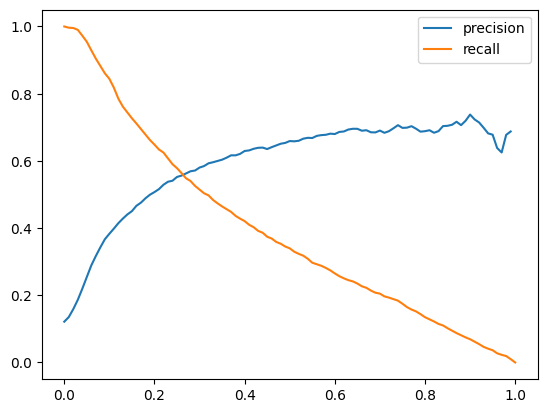

In [49]:
import matplotlib.pyplot as plt
plt.plot(df_p_r.threshold, df_p_r['precision'], label='precision')
plt.plot(df_p_r.threshold, df_p_r['recall'], label='recall')
plt.legend()

The answer: precision and recall curves intersect at t=0.265

# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1: F1 = 2 * (P*R)/(P+R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.02, 0.22, 0.42, 0.62?

In [50]:
def f1_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    #df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    #df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    df_scores['f1'] = 2 * (df_scores['precision']*df_scores['recall'])/(df_scores['precision']+df_scores['recall'])
    
    return df_scores

In [51]:
df_f1 = f1_dataframe(y_val, y_pred)

In [53]:
df_f1.head()

,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.00,1098,7944,0,0,0.121433,1.000000,0.216568
1,0.01,1094,7004,4,940,0.135095,0.996357,0.237930
2,0.02,1093,5788,5,2156,0.158843,0.995446,0.273969
3,0.03,1087,4742,11,3202,0.186481,0.989982,0.313844
4,0.04,1068,3799,30,4145,0.219437,0.972678,0.358089


In [54]:
df_f1.iloc[df_f1.f1.idxmax()]

threshold       0.220000
tp            686.000000
fp            611.000000
fn            412.000000
tn           7333.000000
precision       0.528913
recall          0.624772
f1              0.572860
Name: 22, dtype: float64

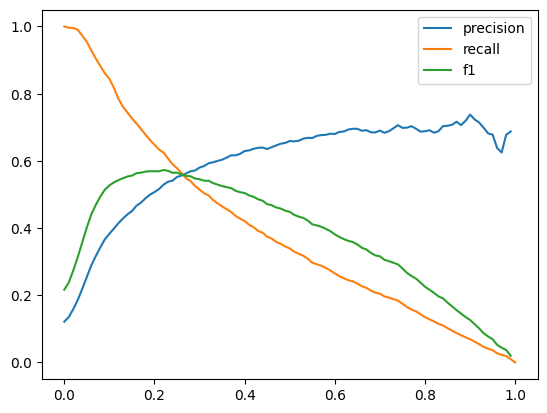

In [56]:
plt.plot(df_f1.threshold, df_f1['precision'], label='precision')
plt.plot(df_f1.threshold, df_f1['recall'], label='recall')
plt.plot(df_f1.threshold, df_f1['f1'], label='f1')
plt.legend()

The answer is: F1 is max at t=0.22

# Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

* KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

* 0.0001, 0.006, 0.06, 0.26?

In [57]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

/Users/irakokoshko/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [59]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [63]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(np.mean(scores), np.std(scores))

0.9060282432067476 0.005621314202146361


In [64]:
scores

[0.8997612748963668,
 0.8989520106005618,
 0.9112064444263073,
 0.9080491260685412,
 0.9121723600419614]

The answer: standard deviation of the scores across different folds = 0.006

# Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.000001, 0.001, 1]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.000001, 0.001, 1?

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [65]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 33%|███████████████                              | 1/3 [00:02<00:05,  2.51s/it]

C=1e-06 0.701 +- 0.009


 67%|██████████████████████████████               | 2/3 [00:05<00:02,  2.67s/it]

C=0.001 0.861 +- 0.007


100%|█████████████████████████████████████████████| 3/3 [00:08<00:00,  2.76s/it]

C=1 0.906 +- 0.006


The answer: C=1 leads to the best mean score